In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)
    

In [4]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if type(true_params[i][j]) != int:
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

In [5]:
DATASET = "2020-10-18-0"
params_true = np.load(f'params_true_{DATASET}.npy', allow_pickle=True)

NUM_CELLS = params_true.shape[0]
NUM_PATTERNS = params_true.shape[1]
ms = [1, 2, 3, 4]

amps_scan = np.array([np.array(np.meshgrid(np.linspace(-2, 2, 21), 
                                np.linspace(-2, 2, 21),
                                np.linspace(-2, 2, 21))).T.reshape(-1,3)] * NUM_PATTERNS)

probs_true_scan = np.zeros((NUM_CELLS, NUM_PATTERNS, amps_scan.shape[1]))

for i in range(len(probs_true_scan)):
    for j in range(len(probs_true_scan[i])):
        if type(params_true[i][j]) != int:
            probs_true_scan[i][j] = fitting.sigmoidND_nonlinear(
                                    sm.add_constant(amps_scan[j], has_constant='add'), 
                                    params_true[i][j])
        else:
            probs_true_scan[i][j] = np.zeros(amps_scan.shape[1])

[[-9.05250954 -1.60328701 -7.41973929 -1.89651072]
 [-9.96257856  1.55000659  6.68682711  1.79503211]]


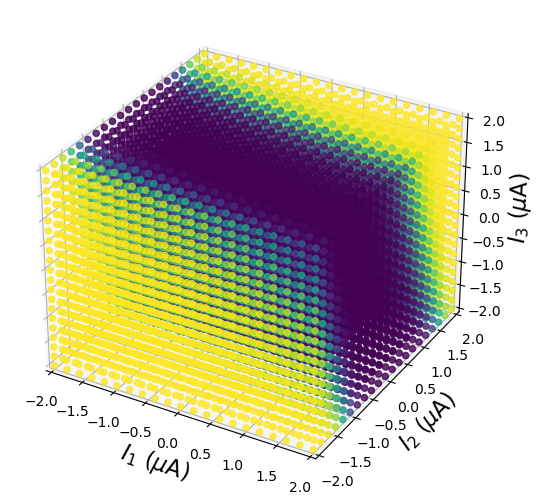

[[-6.64318363  3.24014609  3.17146639  0.94208318]
 [-6.54965278 -3.52446888 -3.53392289 -1.31756334]]


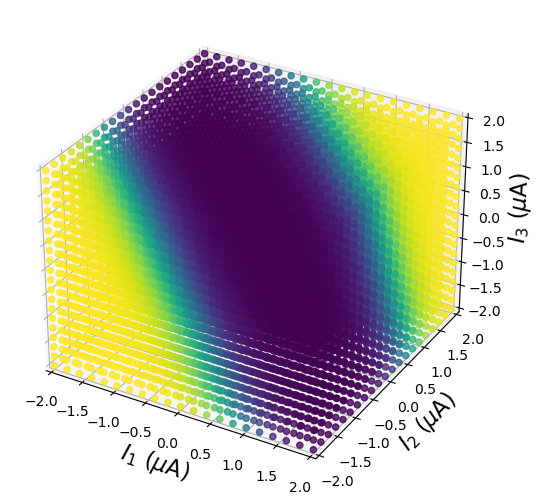

[[ -8.79078657   4.02675263  10.           2.18738162]
 [ -7.26764543  -3.76691306 -10.          -2.13794106]]


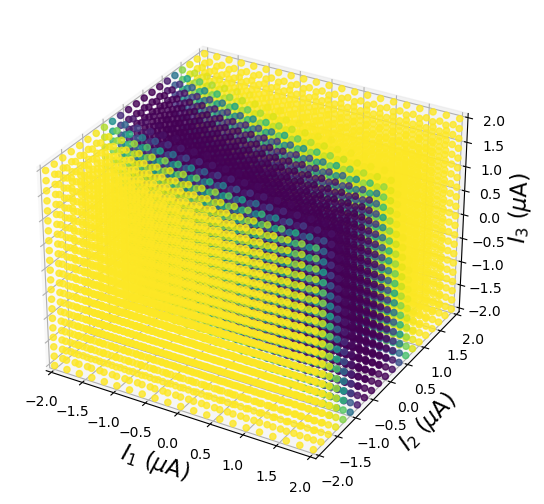

[[-16.27662665   0.1971814   -0.77148809  -8.72097583]
 [-10.12415522  -4.72732415  -2.14381703   1.27001346]
 [ -8.34577779   1.96567874   1.5185649    2.32171069]]


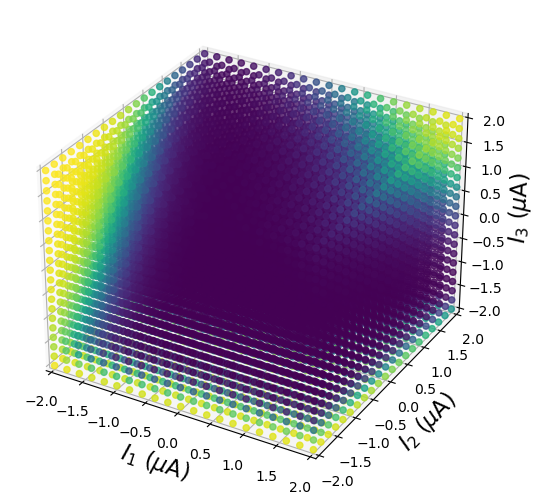

[[-8.69446669 -3.96539453 -3.05038961 -2.47503176]
 [-8.75481397  3.76581798  2.93258749  2.46818877]]


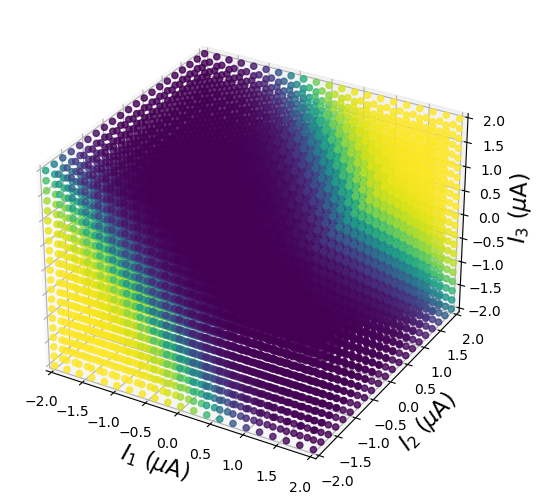

[[-7.71080518 -2.29211519 -1.52422466 -2.77744142]
 [-8.10409183  1.82621177  1.42012664  2.58286728]]


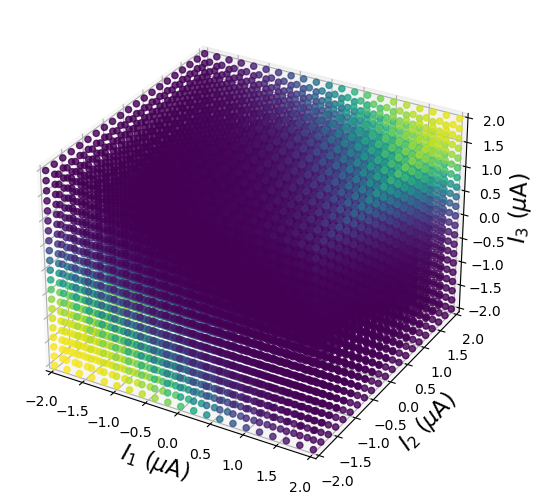

[[-7.10484372  1.80125319  1.90539274  1.72988846]
 [-9.52469798 -2.97798417 -1.40183153 -2.85886332]]


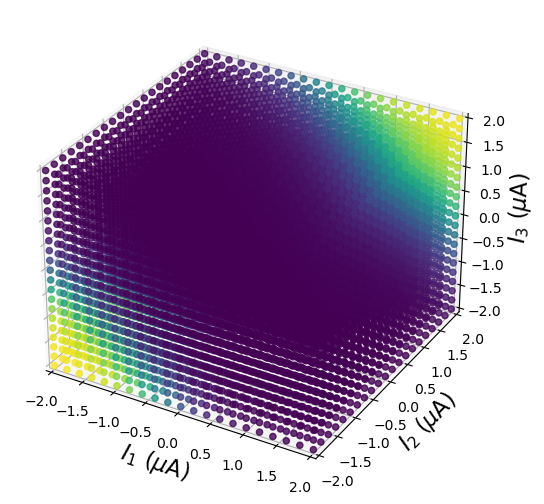

[[-12.53858453   3.07788901   6.32972174   3.57851574]
 [ -8.44255331  -2.26103064  -1.97199385  -2.03543091]]


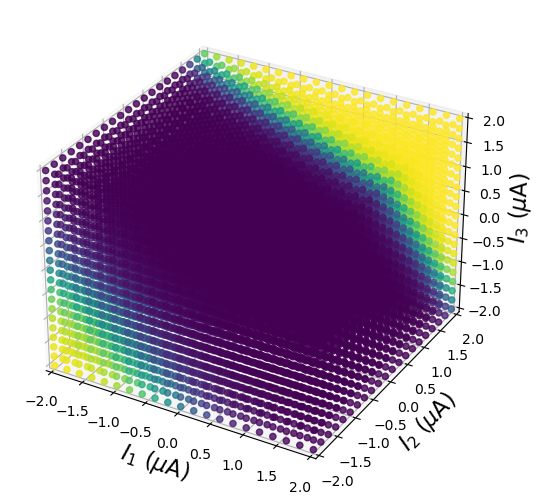

[[-19.03993545   8.88239699  -0.3273005    1.65565469]
 [-16.48214098 -10.           0.62706225  -1.20407434]]


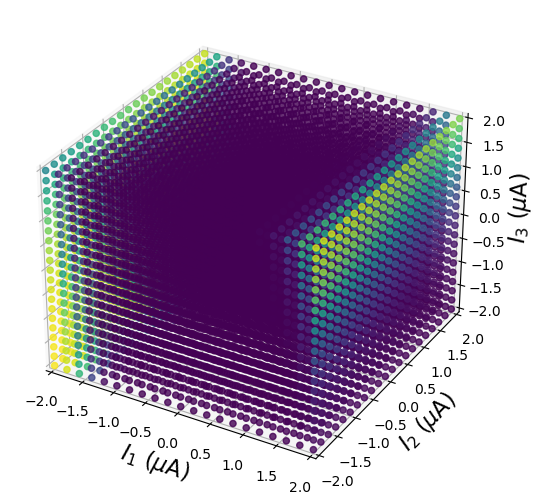

[[-9.52566284e+00 -7.42356109e-01  1.62832143e+00 -6.05971440e+00]
 [-7.97962673e+00  3.09803305e+00  1.00000000e+01  1.08490691e+00]
 [-1.18047998e+01  2.77134168e-01 -5.76032831e+00  6.71696578e+00]
 [-6.33975185e+00 -2.52857643e+00 -1.00000000e+01 -7.16100705e-03]]


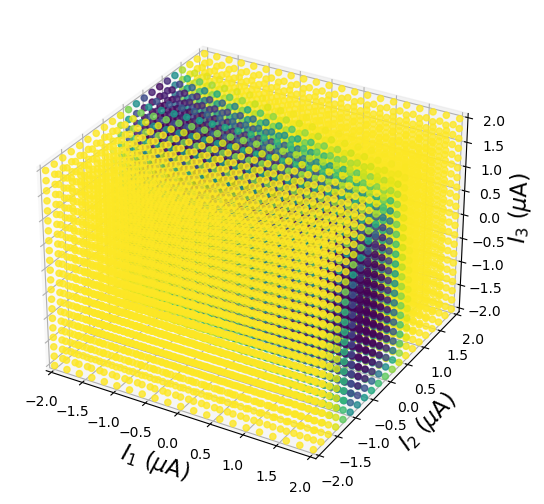

[[-7.70804223 -4.54857309 -1.49757974 -1.53353483]
 [-7.55806956  3.85882481  1.50215459  1.25211252]]


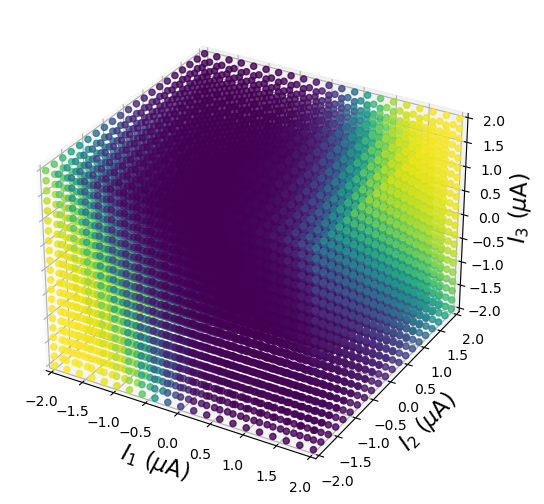

[[ -9.90390819   0.67442109   2.21911321   3.54055169]
 [-11.58061187  -0.61170239  -3.053604    -4.76028497]]


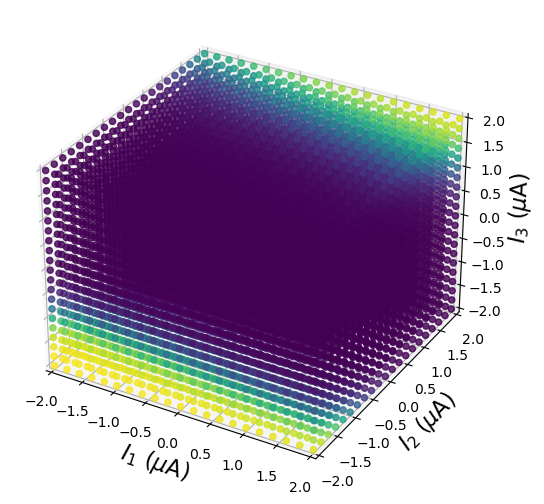

In [6]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(probs_true_scan)):
    for j in range(len(probs_true_scan[i])):
        if type(params_true[i][j]) != int:

            print(params_true[i][j])
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            ax.set_zlim(-2, 2)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_true_scan[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()

Setting up data...
Generating input list...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(609108.25, dtype=float32), DeviceArray(7987.2295, dtype=float32), DeviceArray(720165.1, dtype=float32), DeviceArray(111056.89, dtype=float32))
1
(DeviceArray(501298.12, dtype=float32), DeviceArray(8325.424, dtype=float32), DeviceArray(625875.5, dtype=float32), DeviceArray(124577.38, dtype=float32))
2
(DeviceArray(542732.5, dtype=float32), DeviceArray(7806.233, dtype=float32), DeviceArray(646553.44, dtype=float32), DeviceArray(103820.92, dtype=float32))
3
(DeviceArray(481375.4, dtype=float32), DeviceArray(7308.8843, dtype=float32), DeviceArray(565313.06, dtype=float32), DeviceArray(83937.68, dtype=float32))
4
(DeviceArray(428005.2, dtype=float32), DeviceArray(7810.0854, dtype=float32), DeviceArray(531980.1, dtype=float32), DeviceArray(103974.945, dtype=float32))
5
(DeviceArray(376857.94, dtype=float32), DeviceArray(8166.965, dtype=float32), DeviceArray(495100.38, dt

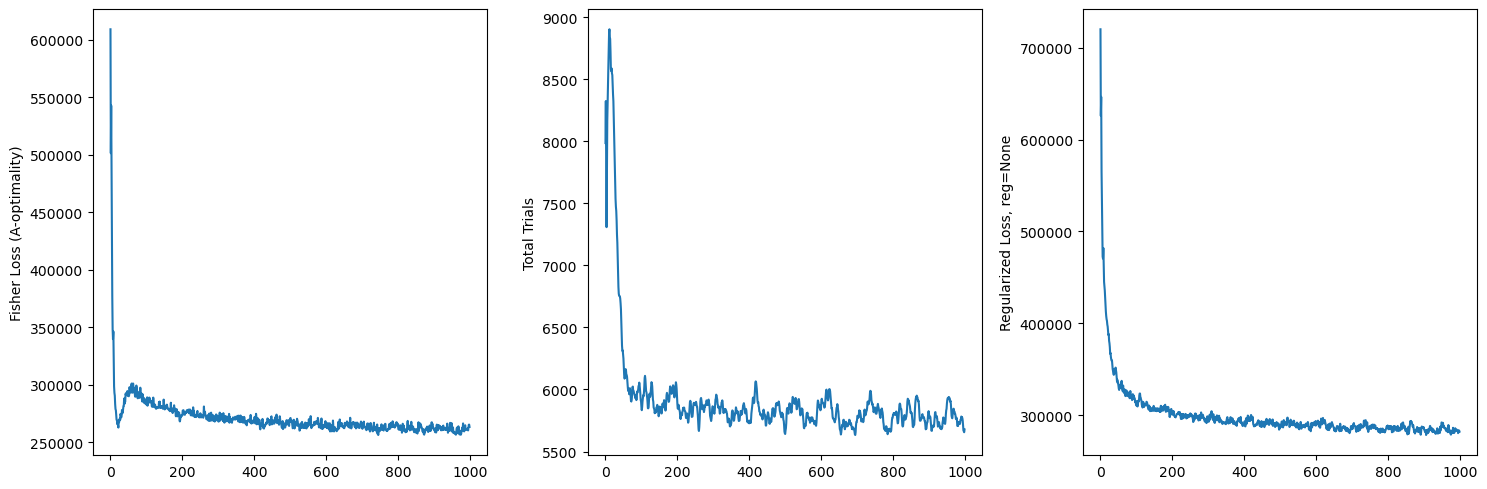

0.03784793647595411 0.03784793647595411


/tmp/ipykernel_4343/394153089.py:121: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Generating input list...
Fitting dataset...


/tmp/ipykernel_4343/394153089.py:134: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(201794.11, dtype=float32), DeviceArray(7987.2295, dtype=float32), DeviceArray(232562.6, dtype=float32), DeviceArray(30768.488, dtype=float32))
1
(DeviceArray(187166.16, dtype=float32), DeviceArray(8312.035, dtype=float32), DeviceArray(221532.22, dtype=float32), DeviceArray(34366.066, dtype=float32))
2
(DeviceArray(183006.4, dtype=float32), DeviceArray(7787.8867, dtype=float32), DeviceArray(211566.95, dtype=float32), DeviceArray(28560.547, dtype=float32))
3
(DeviceArray(188874.22, dtype=float32), DeviceArray(7116.843, dtype=float32), DeviceArray(210002.22, dtype=float32), DeviceArray(21127.996, dtype=float32))
4
(DeviceArray(177677.38, dtype=float32), DeviceArray(7666.8203, dtype=float32), DeviceArray(204896.98, dtype=float32), DeviceArray(27219.604, dtype=float32))
5
(DeviceArray(175379.28, dtype=float32), DeviceArray(7923.8965, dtype=float32), DeviceArray(205446.28, dtype=float32), DeviceArray(30067.004, dtype=float32))
6
(De

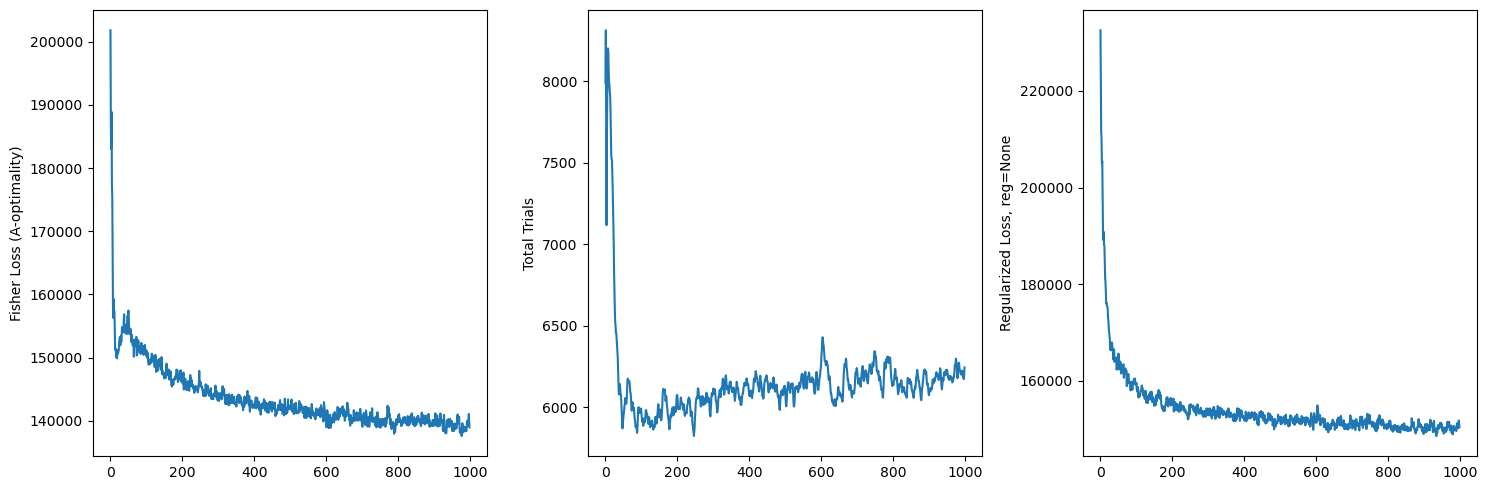

0.015219747243715186 0.023428864633585525


/tmp/ipykernel_4343/394153089.py:121: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Generating input list...
Fitting dataset...


/tmp/ipykernel_4343/394153089.py:134: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(115291.234, dtype=float32), DeviceArray(7987.2295, dtype=float32), DeviceArray(132201.27, dtype=float32), DeviceArray(16910.03, dtype=float32))
1
(DeviceArray(110465.19, dtype=float32), DeviceArray(8281.913, dtype=float32), DeviceArray(129169.05, dtype=float32), DeviceArray(18703.86, dtype=float32))
2
(DeviceArray(112617.11, dtype=float32), DeviceArray(7720.4824, dtype=float32), DeviceArray(127903.37, dtype=float32), DeviceArray(15286.259, dtype=float32))
3
(DeviceArray(114377.17, dtype=float32), DeviceArray(6969.9707, dtype=float32), DeviceArray(125094.836, dtype=float32), DeviceArray(10717.664, dtype=float32))
4
(DeviceArray(111812.195, dtype=float32), DeviceArray(7463.3037, dtype=float32), DeviceArray(125532.93, dtype=float32), DeviceArray(13720.733, dtype=float32))
5
(DeviceArray(109770.375, dtype=float32), DeviceArray(7682.5244, dtype=float32), DeviceArray(124825.57, dtype=float32), DeviceArray(15055.196, dtype=float32))


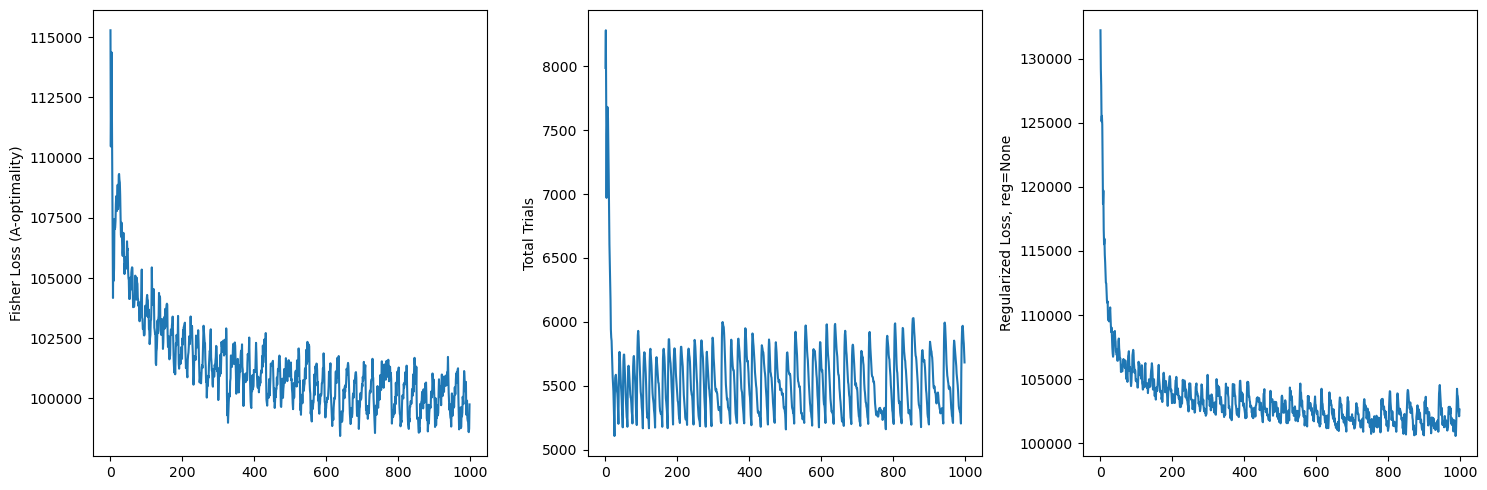

0.01127111520611975 0.021006346362850842


/tmp/ipykernel_4343/394153089.py:121: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Generating input list...
Fitting dataset...


/tmp/ipykernel_4343/394153089.py:134: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(83891.055, dtype=float32), DeviceArray(7987.2295, dtype=float32), DeviceArray(96020.12, dtype=float32), DeviceArray(12129.064, dtype=float32))
1
(DeviceArray(81956.17, dtype=float32), DeviceArray(8243.135, dtype=float32), DeviceArray(95202.58, dtype=float32), DeviceArray(13246.409, dtype=float32))
2
(DeviceArray(82427.766, dtype=float32), DeviceArray(7794.3213, dtype=float32), DeviceArray(93714.55, dtype=float32), DeviceArray(11286.78, dtype=float32))
3
(DeviceArray(81300.55, dtype=float32), DeviceArray(7027.629, dtype=float32), DeviceArray(89239.76, dtype=float32), DeviceArray(7939.214, dtype=float32))
4
(DeviceArray(80635.234, dtype=float32), DeviceArray(7151.71, dtype=float32), DeviceArray(89116.22, dtype=float32), DeviceArray(8480.981, dtype=float32))
5
(DeviceArray(80590.11, dtype=float32), DeviceArray(7139.707, dtype=float32), DeviceArray(89018.69, dtype=float32), DeviceArray(8428.574, dtype=float32))
6
(DeviceArray(8103

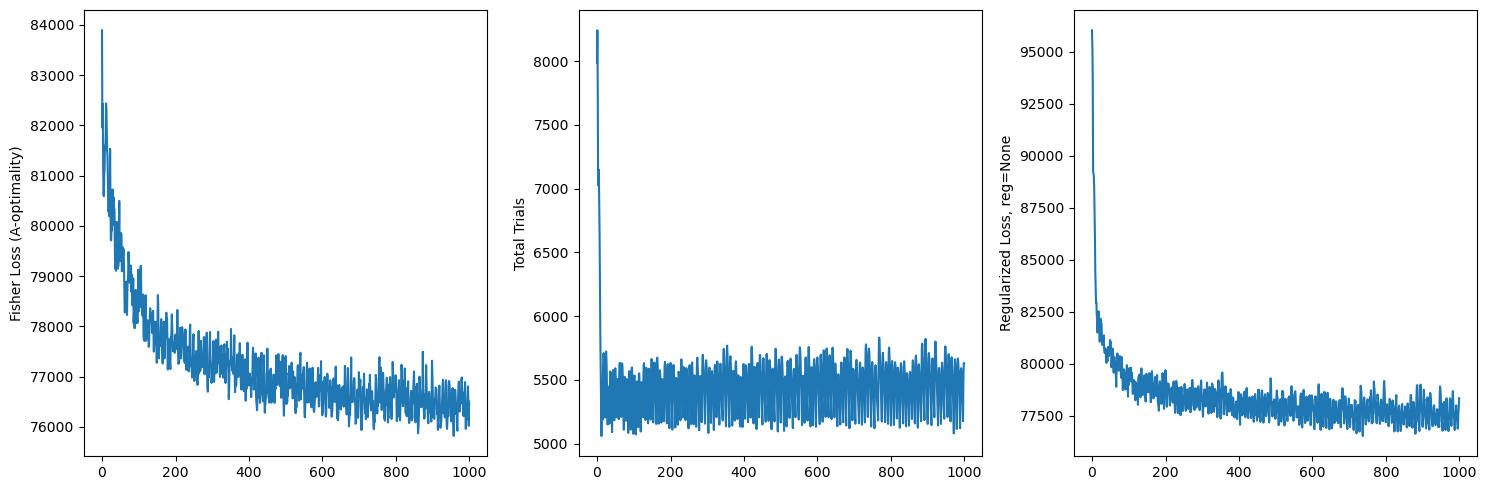

0.009297417715386487 0.01930714316094406


/tmp/ipykernel_4343/394153089.py:121: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Generating input list...
Fitting dataset...


/tmp/ipykernel_4343/394153089.py:134: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(67027.38, dtype=float32), DeviceArray(7987.2295, dtype=float32), DeviceArray(76641.93, dtype=float32), DeviceArray(9614.544, dtype=float32))
1
(DeviceArray(65515.562, dtype=float32), DeviceArray(8212.477, dtype=float32), DeviceArray(75909.7, dtype=float32), DeviceArray(10394.138, dtype=float32))
2
(DeviceArray(65952.67, dtype=float32), DeviceArray(7557.701, dtype=float32), DeviceArray(74080.59, dtype=float32), DeviceArray(8127.9194, dtype=float32))
3
(DeviceArray(67707., dtype=float32), DeviceArray(6603.493, dtype=float32), DeviceArray(72532.34, dtype=float32), DeviceArray(4825.346, dtype=float32))
4
(DeviceArray(66607.56, dtype=float32), DeviceArray(6836.3594, dtype=float32), DeviceArray(72238.875, dtype=float32), DeviceArray(5631.3105, dtype=float32))
5
(DeviceArray(66128.516, dtype=float32), DeviceArray(6811.8867, dtype=float32), DeviceArray(71675.125, dtype=float32), DeviceArray(5546.609, dtype=float32))
6
(DeviceArray(659

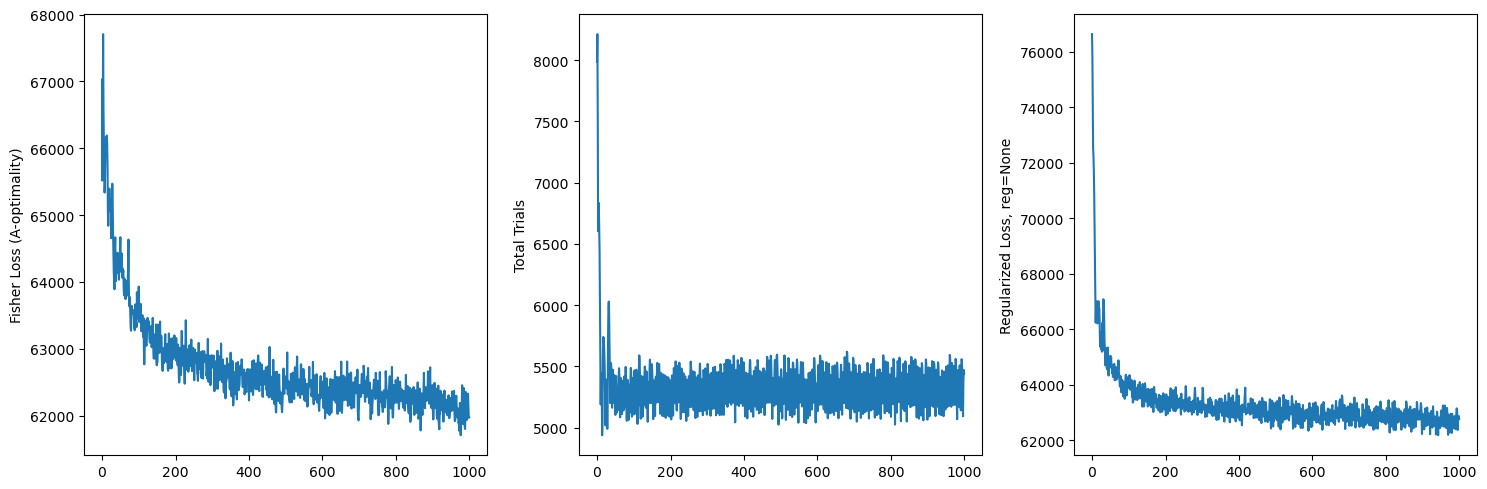

0.008128023979359824 0.01876684435762593


/tmp/ipykernel_4343/394153089.py:121: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Generating input list...
Fitting dataset...


/tmp/ipykernel_4343/394153089.py:134: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(56824.406, dtype=float32), DeviceArray(7987.2295, dtype=float32), DeviceArray(64937.477, dtype=float32), DeviceArray(8113.069, dtype=float32))
1
(DeviceArray(55792.89, dtype=float32), DeviceArray(8193.746, dtype=float32), DeviceArray(64509.1, dtype=float32), DeviceArray(8716.213, dtype=float32))
2
(DeviceArray(55006.527, dtype=float32), DeviceArray(7511.2935, dtype=float32), DeviceArray(61729.598, dtype=float32), DeviceArray(6723.07, dtype=float32))
3
(DeviceArray(55991.24, dtype=float32), DeviceArray(6477.8643, dtype=float32), DeviceArray(59696.117, dtype=float32), DeviceArray(3704.8796, dtype=float32))
4
(DeviceArray(55732.29, dtype=float32), DeviceArray(6769.8096, dtype=float32), DeviceArray(60289.812, dtype=float32), DeviceArray(4557.523, dtype=float32))
5
(DeviceArray(55506.375, dtype=float32), DeviceArray(6652.6533, dtype=float32), DeviceArray(59721.734, dtype=float32), DeviceArray(4215.3613, dtype=float32))
6
(DeviceArr

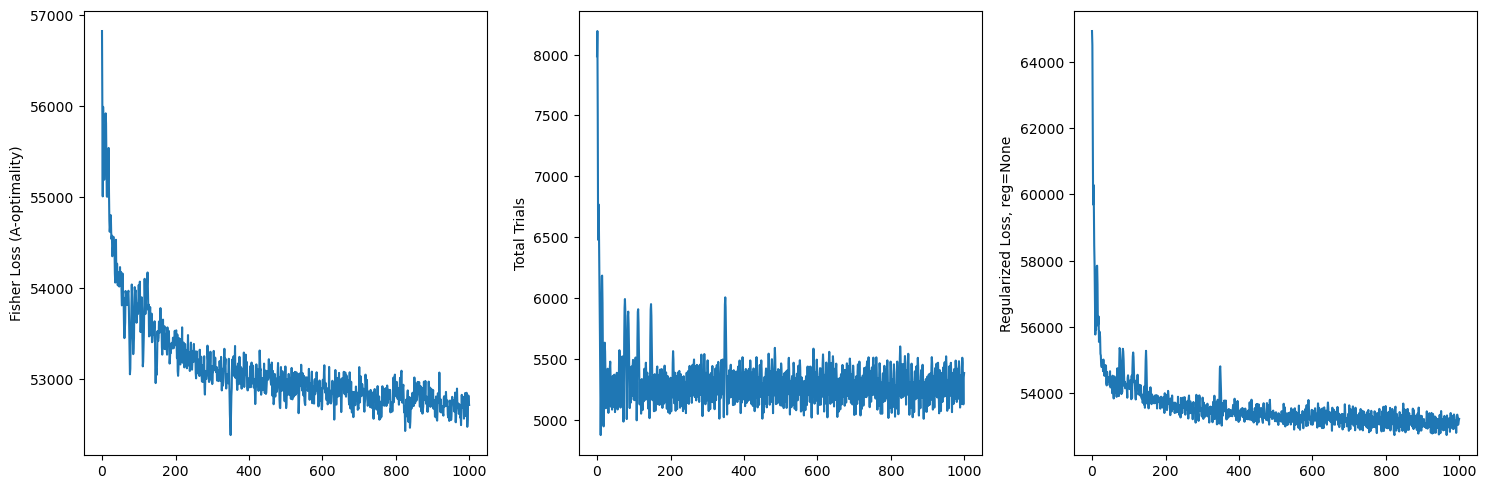

0.007746661869789505 0.016704791951431777


In [7]:
num_iters = 5

T_prev = np.zeros((amps_scan.shape[0], amps_scan.shape[1]), dtype=float)
budget = T_prev.shape[0] * T_prev.shape[1] * 0.25 #int(total_budget / num_iters)
reg = None # 20, 50
T_step_size = 0.1 # 0.05, 0.01
T_n_steps = 1000    # 5000

init_trials = 5
init_amps = 200
ms = [1, 2, 3, 4]
disambiguate = True
verbose = True
R2_cutoff = 0
prob_low = 1 / init_trials
min_inds = 5
exploit_factor = 0.75
entropy_samples = 1
trial_cap = 100

for i in range(len(T_prev)):
    init_inds = np.random.choice(np.arange(len(T_prev[i]), dtype=int), size=init_amps,
                                 replace=False)
    T_prev[i][init_inds] = init_trials

T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true_scan, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_scan,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low,
                                        min_inds=min_inds,
                                        exploit_factor=exploit_factor, 
                                        entropy_samples=entropy_samples,
                                        trial_cap=trial_cap)

        performance = get_performance_array(params_true, probs_curr, probs_true_scan)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_scan,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        # t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low,
                                        min_inds=min_inds,
                                        exploit_factor=exploit_factor,
                                        entropy_samples=entropy_samples,
                                        trial_cap=trial_cap)

        
        performance = get_performance_array(params_true, probs_curr, probs_true_scan)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps_scan, 
                                                            T_prev_uniform, w_inits_array_uniform, prob_low,
                                                            disambiguate=disambiguate, min_inds=min_inds)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_scan[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true_scan)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true_scan, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    random_extra = np.random.choice(len(T_new.flatten()), size=int(np.sum(T_new)), replace=True)
    T_new_uniform = np.array(np.bincount(random_extra, minlength=len(T_new.flatten())).astype(int).reshape(T_new.shape), dtype=float)
    # T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    p_new_uniform = sample_spikes_array(probs_true_scan, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [8]:
baseline_trials = 20
T_prev_baseline = np.ones_like(T_prev, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true_scan, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_scan[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps_scan, T_prev_baseline, w_inits_array_baseline, 1 / baseline_trials,
                                                    disambiguate=disambiguate, min_inds=min_inds)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_scan[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true_scan)

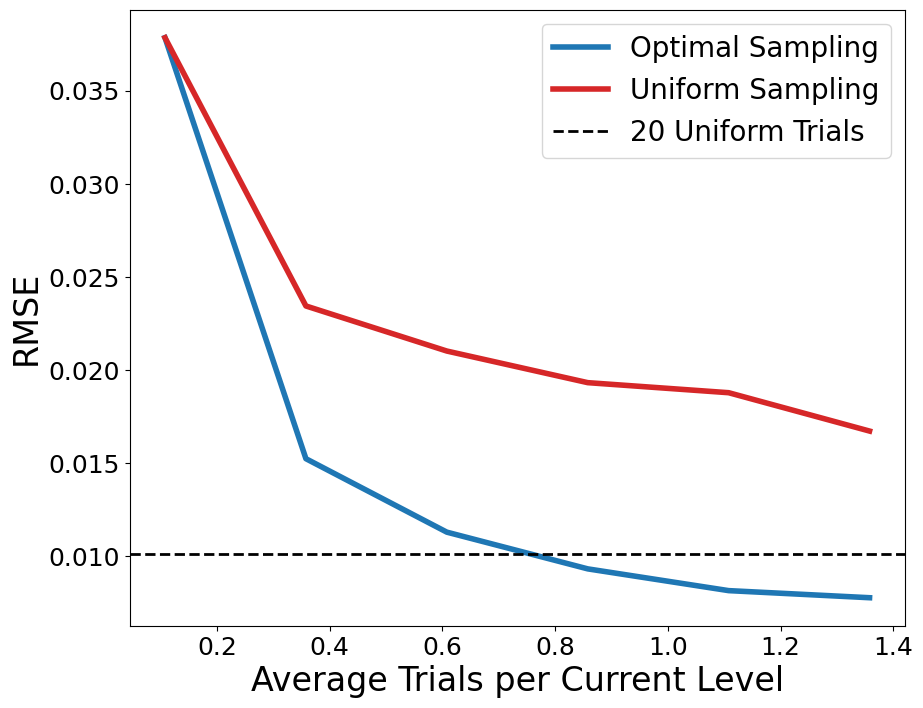

In [9]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/T_prev.shape[0]/T_prev.shape[1], performances, linewidth=4, c='tab:blue', label='Optimal Sampling')
plt.plot(np.array(num_samples_uniform)/T_prev_uniform.shape[0]/T_prev_uniform.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label=f'{baseline_trials} Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

plt.savefig(f'triplet_AL_fakedata_{DATASET}.png', dpi=300)

In [ ]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(probs_true_scan)):
    for j in range(len(probs_true_scan[i])):
        if type(params_true[i][j]) != int:

            print(params_true[i][j])
            sampled_inds = np.where(T_prev[j] > 0)[0]
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_true_scan[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()


            print(params_curr[i][j])
            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_curr[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][sampled_inds, 0], 
                              amps_scan[j][sampled_inds, 1],
                              amps_scan[j][sampled_inds, 2], marker='o', 
                              c=probs_empirical[i][j][sampled_inds], 
                              s=T_prev[j][sampled_inds], alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()